In [1]:
#!/usr/bin/env python
# -*- coding:utf-8 -*- 
import numpy as np
import pandas as pd
import datetime
import urllib2
import json
import pymysql

In [2]:
def getData(factorName):
    conf = {
    "TOKEN_URL":"http://auth.yunkuanke.com/oauth/token",
	"TOKEN_BODY":"client_id=ContentClient&client_secret=1249389CD9CA4429939689C9DDE19CFE&grant_type=password&scope=read&username=admin&password=admin",
	"TOKEN_HEADERS":{"Content-Type":"application/x-www-form-urlencoded;charset=UTF-8"},
	"DATA_URL":"http://factorapi.yunkuanke.com/factor/downloadFileByFacCode.do?factorCode="
    }

    req = urllib2.Request(url=conf["TOKEN_URL"], data=conf["TOKEN_BODY"], headers=conf["TOKEN_HEADERS"])
    res = urllib2.urlopen(req).read()
    token = json.loads(json.loads(res)['data'])["access_token"]
    req = urllib2.Request(url=conf["DATA_URL"] + factorName + "&access_token=" + token)
    return pd.read_csv(urllib2.urlopen(req),parse_dates=True,index_col=0,encoding='gb2312')

In [3]:
product_name='CE295F46B5D94544A86591A33673C621'

In [4]:
def get_date(product_name):
    conn = pymysql.connect(host='192.168.10.233', port=3306, user='test1', passwd='123456', db='risk',charset='utf8')
    sql0 = "select max(trade_date) from tbl_fund_future_statement WHERE product_code='{0}'".format(product_name)
    date=pd.read_sql(sql0,conn)['max(trade_date)'].values[0].strftime('%Y-%m-%d')
    conn.close()
    return date
def get_product(product_name):
    conn = pymysql.connect(host='192.168.10.233', port=3306, user='test1', passwd='123456', db='risk',charset='utf8')
    date=get_date(product_name)
    sql1 = "select * from product_list WHERE product_id='{0}'".format(product_name)
    res=pd.read_sql(sql1,conn,index_col='productid')
    conn.close()
    return  res
    
    
def get_future(product_name):
    conn = pymysql.connect(host='192.168.10.233', port=3306, user='test1', passwd='123456', db='risk',charset='utf8')
    date=get_date(product_name)
    sql2 = "select * from tbl_fund_future_statement WHERE product_code='{0}' and trade_date='{1}'".format(product_name,date)
    res=pd.read_sql(sql2,conn,index_col='Id')
    conn.close()
    return  res
def get_fposition(product_name):
    conn = pymysql.connect(host='192.168.10.233', port=3306, user='test1', passwd='123456', db='risk',charset='utf8')
    date=get_date(product_name)
    sql3 = "select * from tbl_fund_future_statement_position WHERE product_code='{0}'and trade_date='{1}'".format(product_name,date)
    res=pd.read_sql(sql3,conn,index_col='Contract_Name')
    conn.close()
    return res
def get_stock(product_name):
    conn = pymysql.connect(host='192.168.10.233', port=3306, user='test1', passwd='123456', db='risk',charset='utf8')
    sql0 = "select max(trade_date) from tbl_fund_future_statement WHERE product_code='{0}'".format(product_name)
    date=pd.read_sql(sql0,conn)['max(trade_date)'].values[0].strftime('%Y-%m-%d')
    sql4 = "select * from tbl_fund_stock_statement WHERE product_code='{0}'and query_date='{1}'".format(product_name,date)
    res=pd.read_sql(sql4,conn,index_col='Id')
    conn.close()
    return res
def get_spostion(product_name):
    conn = pymysql.connect(host='192.168.10.233', port=3306, user='test1', passwd='123456', db='risk',charset='utf8')
    date=get_date(product_name)
    sql5 = "select * from tbl_fund_stock_statement_position WHERE product_code='{0}'and query_date='{1}'".format(product_name,date)
    res=pd.read_sql(sql5,conn,index_col='Id')
    conn.close()
    return res
def get_valuation(product_name):
    conn = pymysql.connect(host='192.168.10.233', port=3306, user='test1', passwd='123456', db='risk',charset='utf8')
    date=get_date(product_name)
    sql6 = "select * from tbl_fund_valuation WHERE Product_code='{0}'and Valuation_Date='{1}'".format(product_name,date)
    res=pd.read_sql(sql6,conn,index_col='Id')
    conn.close()
    return res

In [5]:
'''商品期货数据'''
def get_commodity(product_name):
    fposition=get_fposition(product_name)
    futures=get_futures(product_name)
    future=get_future(product_name)
    stock=get_stock(product_name)
    commodity=pd.DataFrame()
    value_now=future['Customer_Equity'].values[0]+stock['Total_Assets'].values[0]
    commodity_name=filter(lambda x:filter(str.isalpha,str(x)).upper() not in ['IF','IH','IC'],futures['contract'].values)
    commodity['contract']=commodity_name
    commodity['value']=fposition.ix[commodity_name,'Market_Value'].values
    commodity['margin']=fposition.ix[commodity_name,'Margin'].values
    commodity['type']=fposition.ix[commodity_name,'Position_Type'].values
    commodity['value_weight_at_product']=commodity['value']/value_now
    commodity['margin_weight_at_product']=commodity['margin']/value_now
    return commodity

'''股指期货数据'''
def get_IF(product_name):
    fposition=get_fposition(product_name)
    future=get_future(product_name)
    futures=get_futures(product_name)
    stock=get_stock(product_name)
    value_now=future['Customer_Equity'].values[0]+stock['Total_Assets'].values[0]
    IF=pd.DataFrame()
    IF_name=filter(lambda x:filter(str.isalpha,str(x)).upper() in ['IF','IH','IC'],futures['contract'].values)
    IF['contract']=IF_name
    IF['value']=fposition.ix[IF_name,'Market_Value'].values
    IF['margin']=fposition.ix[IF_name,'Margin'].values
    IF['type']=fposition.ix[IF_name,'Position_Type'].values
    IF['value_weight_at_product']=IF['value']/value_now
    IF['margin_weight_at_product']=IF['margin']/value_now
    return IF

'''股票数据'''
def get_stocks(product_name):
    spostion=get_spostion(product_name)
    stocks=pd.DataFrame()
    stocks['code']= spostion['Stock_Code'].values
    stocks['value'] = spostion['Stock_Market_Value'].values
    stocks=stocks[stocks['value']>0]
    stocks['w']=stocks['value']/sum(stocks['value'])
    return stocks
'''期货数据'''
def get_futures(product_name):
    fposition=get_fposition(product_name)
    future=get_future(product_name)
    stock=get_stock(product_name)
    value_now=future['Customer_Equity'].values[0]+stock['Total_Assets'].values[0]
    futures=pd.DataFrame()
    futures['contract']=fposition.index
    futures['value']=fposition['Market_Value'].values
    futures['margin']=fposition['Margin'].values
    futures['type']=fposition['Position_Type'].values
    futures['value_weight_at_product']=futures['value']/value_now
    futures['margin_weight_at_product']=futures['margin']/value_now
    return futures
'''产品数据'''
def get_product_value(product_name):
    product=get_product(product_name)
    futures=get_futures(product_name)
    IF=get_IF(product_name)
    commodity=get_commodity(product_name)
    future=get_future(product_name)
    stock=get_stock(product_name)
    product_value=pd.Series(index=['initial','future','future_long','future_short','commodity','commodity_short','commodity_long','stock','IF','IF_long','IF_short','fund','bond','option','option_long','option_short','now'],data=0.0)
    product_value['initial']=product['initial_value'].values[0]
    product_value['future_long']=sum(futures['value'][futures['type']==1])
    product_value['future_short']=sum(futures['value'][futures['type']==2])
    product_value['IF']=sum(IF['value'])
    product_value['IF_long']=sum(IF['value'][IF['type']==1])
    product_value['IF_short']=sum(IF['value'][IF['type']==2])
    product_value['commodity']=sum(commodity['value'])
    product_value['commodity_long']=sum(commodity['value'][commodity['type']==1])
    product_value['commodity_short']=sum(commodity['value'][commodity['type']==2])
    product_value['future']=future['Customer_Equity'].values[0]
    product_value['stock']=stock['Total_Assets'].values[0]
    product_value['now'] = product_value['future']+product_value['stock']
    return product_value


In [7]:
#产品相关规则

'''获取净值'''
def get_unit_value(product_name):
    product_value=get_product_value(product_name)
    return product_value['now']/float(product_value['initial'])

'''持有的股票、股票型及混合型证券投资基金市值与买入、卖出股指期货、期权合约价值，合计（轧差计算）占基金资产净值的比例'''
def get_stocks_funds_IF_option_weight(product_name):
    product_value=get_product_value(product_name)
    return (product_value['stock']+product_value['option_long']+product_value['fund']+product_value['IF_long']-product_value['option_short']-product_value['IF_short'])/product_value['now']

'''股票相关多空净敞口占净值比例'''
def get_stocks_long_short_weight(product_name):
    product_value=get_product_value(product_name)
    return (product_value['stock']+product_value['option_long']+product_value['IF_long']-product_value['option_short']-product_value['IF_short'])/product_value['now']

'''股票现货及股指期货合约价值（非轧差）占比'''
def get_stocks_IF_weight_NO_offset(product_name):
    product_value=get_product_value(product_name)
    return (product_value['stock']+product_value['IF'])/product_value['now']

'''股票现货及股指期货合约价值（轧差）占比'''
def get_stocks_IF_weight_offset(product_name):
    product_value=get_product_value(product_name)
    return (product_value['stock']+product_value['IF_long']-product_value['IF_short'])/product_value['now']

In [8]:
#股票相关规则

'''获取行业权重'''
def get_sector_weight(product_name):
    stocks=get_stocks(product_name)
    s=getData('LZ_GPA_TMP_INDU_ZX')
    s['weight']=0
    sector=getData('LZ_GPA_TMP_INDU_ZX')
    sector_info=getData('LZ_GPA_INDU_ZX')
    date=get_date(product_name)
    sector_info=sector_info.ix[date]
    sector_info.index=sector_info.index.map(lambda x:x.split('.')[0])
    stocks['sector'] = sector_info[stocks['code']].astype(int).values
    s.ix[stocks.groupby('sector').sum().index-1,'weight']=stocks.groupby('sector').sum()['w'].values
    return s

'''获取创业板权重'''
def get_GEM_weight(product_name):
    stocks=get_stocks(product_name)
    GEM = stocks[stocks['code'].map(lambda x:x[:3])=='300']
    return sum(GEM['w'])

'''获取ST股票权重'''
def get_ST_weight(product_name):
    stocks=get_stocks(product_name)
    date=get_date(product_name)
    ST=getData('LZ_GPA_SLCIND_ST_FLAG').ix[date]
    ST_stocks=ST[~np.isnan(ST)].index.map(lambda x:x.split('.')[0])
    stocks['is_ST']=stocks['code'].map(lambda x: 1 if x in ST_stocks else 0)
    return sum(stocks[stocks['is_ST']==1]['w'])

'''获取单只股票权重'''
def get_weight(product_name):
    stocks=get_stocks(product_name)
    return stocks[['code','w']]

'''单股票持仓总股本占比'''
def get_TCAP_weight(product_name):
    stocks=get_stocks(product_name)
    date=get_date(product_name)
    TCAP=getData('LZ_GPA_VAL_A_TCAP').ix[date]
    TCAP.index=TCAP.index.map(lambda x:x.split('.')[0])
    stocks['tcap_w']=stocks['value']/(TCAP[stocks['code']].values*10000)
    return stocks[['code','tcap_w']]

'''单股票持仓流通股本占比'''
def get_FCAP_weight(product_name):
    stocks=get_stocks(product_name)
    date=get_date(product_name)
    FCAP=getData('LZ_GPA_VAL_A_FCAP').ix[date]
    FCAP.index=FCAP.index.map(lambda x:x.split('.')[0])
    stocks['fcap_w']=stocks['value']/(FCAP[stocks['code']].values*10000)
    return stocks[['code','fcap_w']]

In [9]:
#期货相关规则

'''投资于股指期货占用保证金占整个期货账户权益的比例'''
def get_all_IF_margin_weight_at_future(product_name):
    IF=get_IF(product_name)
    product_value=get_product_value(product_name)
    return sum(IF['margin'])/product_value['future']

'''持有的单个商品期货品种的合约价值占计划资产净值的比例'''
def get_future_value_weight_at_product(product_name):
    commodity=get_commodity(product_name)
    return commodity[['contract','value_weight_at_product']]

'''持有的全部商品期货合约价值占计划资产净值的比例'''
def get_all_future_value_weight_at_product(product_name):
    product_value=get_product_value(product_name)
    return product_value['commodity']/product_value['now']

'''单一期货品种持仓的期货保证金占本计划财产净值的比例'''
def get_future_margin_weight_at_product(product_name):
    futures=get_futures(product_name)
    product_value=get_product_value(product_name)
    return futures[['contract','margin_weight_at_product']]

'''期货多空净敞口占净值比例'''
def future_open_weight(product_name):
    product_value=get_product_value(product_name)
    return abs(product_value['future_long']-product_value['future_short'])/product_value['now']

'''期货保证金占用（非轧差）'''
def get_all_future_margin_weight_at_future(product_name):
    futures=get_futures(product_name)
    product_value=get_product_value(product_name)
    return sum(futures['margin'])/product_value['future']
    

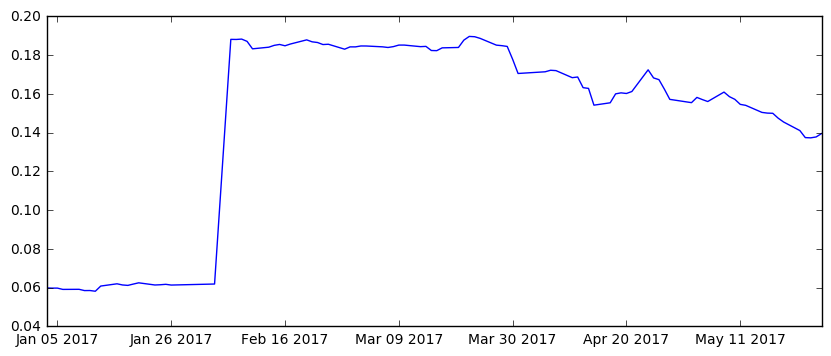

In [185]:
conn = pymysql.connect(host='192.168.10.233', port=3306, user='test1', passwd='123456', db='risk',charset='utf8')
sql0 = "select max(trade_date) from tbl_fund_future_statement WHERE product_code='{0}'".format(product_name)
date=pd.read_sql(sql0,conn)['max(trade_date)'].values[0].strftime('%Y-%m-%d')
sql4 = "select * from tbl_fund_stock_statement_position WHERE product_code='{0}'".format(product_name)
s=pd.read_sql(sql4,conn,index_col='Id',parse_dates=['Query_Date'])
st_w_h=[]
for d in sorted(s['Query_Date'].value_counts().index):
    today_s=s[['Stock_Code','Stock_Market_Value']][s['Query_Date']==d]
    today_s['w']=today_s['Stock_Market_Value']/sum(today_s['Stock_Market_Value'])
    GEM = today_s[today_s['Stock_Code'].map(lambda x:x[:3])=='300']
    st_w_h.append(sum(GEM['w']))
plt.figure(figsize=(10,4))
plt.plot(sorted(s['Query_Date'].value_counts().index),st_w_h)